## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [12]:
small_val = 1e-9

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [2]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
    # 1. 先建立一個 map 記錄每個數字出現幾次
    # 2. 用上面的資訊計算 gini
    total = 0
    quantity_dict = dict()
    for item in sequence:
        if item not in quantity_dict:
            quantity_dict[item] = 1  # if the key not yet in the dictionary -> need to first set the key to the dict
        else:
            quantity_dict[item] += 1  # 對應的 key 數量加一
        total += 1
    
    gini = 1
    for key, value in quantity_dict.items():
        gini -= ((value/total)*(value/total))
    
    return gini


def entropy(sequence):
    total = 0
    quantity_dict = dict()
    for item in sequence:
        if item not in quantity_dict:
            quantity_dict[item] = 1  # if the key not yet in the dictionary -> need to first set the key to the dict
        else:
            quantity_dict[item] += 1  # 對應的 key 數量加一
        total += 1
    
    entropy = 0
    for key, value in quantity_dict.items():
        if value == 0:
            continue  # no change to the entropy
        elif value == total:
            break  # entropy is 0
        else:
            entropy += (value/total)*np.log2(value/total)
    
    return -entropy


In [248]:
# 1 = class 1
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [249]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [250]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [33]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


In [25]:
x_train_data = train_df.drop(columns=['price_range']).to_numpy()
y_train_data = train_df.loc[:, 'price_range'].to_numpy()


x_test_data = val_df.drop(columns=['price_range']).to_numpy()
y_test_data = val_df.loc[:, 'price_range'].to_numpy()

print(x_train_data)
print(y_train_data)

[[1.583e+03 1.000e+00 2.100e+00 ... 1.000e+00 0.000e+00 1.000e+00]
 [7.450e+02 1.000e+00 6.000e-01 ... 1.000e+00 1.000e+00 0.000e+00]
 [8.320e+02 0.000e+00 7.000e-01 ... 1.000e+00 0.000e+00 1.000e+00]
 ...
 [1.195e+03 1.000e+00 1.100e+00 ... 1.000e+00 0.000e+00 0.000e+00]
 [6.710e+02 0.000e+00 9.000e-01 ... 1.000e+00 0.000e+00 0.000e+00]
 [1.845e+03 1.000e+00 5.000e-01 ... 0.000e+00 0.000e+00 0.000e+00]]
[1 0 0 ... 0 1 0]


In [26]:
print(x_train_data.shape[0])
print(x_train_data.shape[1])

1200
20


In [27]:
print(x_train_data[0][0])
print(x_train_data[1][0])

1583.0
745.0


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [3]:
class Node():
    def __init__(self, node_id, left_node_id, right_node_id, feature_id, boundary, label):
        self.node_id = node_id  # self node id
        self.left_node_id = left_node_id  # left child node id
        self.right_node_id = right_node_id  # right child node id
        self.feature_id = feature_id  # id of the split feature
        self.boundary = boundary  # best boundary of the split feature to get min impurity
        self.label = label # 每個點都要記錄自己的 class label -> base on the majority on that time

In [58]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, mode='default', m=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = dict()  # map the node id to the class 'Node' information
        self.node_number = 0
        self.feature_number = 0
        self.use_feature_times = dict()  # key: feature_id, times: use times
        self.x_data = None
        self.y_data = None
        self.all_feature_id_list = []
        self.mode = mode  # 'default' or 'random_forest'
        self.m = m        # random_forest: random select 'm' features for each node

    def fit(self, x_data, y_data):
        self.feature_number = x_data.shape[1]  # x_data's column number is the feature number
        for i in range (self.feature_number):
            self.all_feature_id_list.append(i)
        self.x_data = x_data
        self.y_data = y_data
        data_id_list = []
        for i in range(len(x_data)):  # len(x_data) is row number
            data_id_list.append(i)
        
        self.node_number += 1  # 先加完再 assign 下去
        self.build_tree(data_id_list, depth=0, my_node_number=0)


    def build_tree(self, data_id_list, depth, my_node_number):
        # 1. 深度抵達了 -> do the node record and return
        if depth == self.max_depth:
            label_list = []
            for id in data_id_list:
                label_list.append(self.y_data[id])

            majority_label = max(label_list, key=label_list.count)  # 拿出 label list 中出現最多次的元素
            self.tree[my_node_number] = Node(node_id = my_node_number,
                                             left_node_id = None,
                                             right_node_id = None,
                                             feature_id = None,
                                             boundary = None,
                                             label = majority_label)
            return
        
        # # 1.5 如果 label 都一樣提早結束 -> 寫下面比寫這邊快
        # test_pure_label_list = []
        # for id in data_id_list:
        #     test_pure_label_list.append(self.y_data[id])
        # if(np.unique(test_pure_label_list).shape[0]) == 1:  # pure
        #     majority_label = max(test_pure_label_list, key=test_pure_label_list.count)  # 拿出 label list 中出現最多次的元素
        #     self.tree[my_node_number] = Node(node_id = my_node_number,
        #                                      left_node_id = None,
        #                                      right_node_id = None,
        #                                      feature_id = None,
        #                                      boundary = None,
        #                                      label = majority_label)
        #     return


        # 2. find best feature to split the dataset
        #    -> iterate through features
        #    -> for each feature, find the best boundary
        # ** for the m random feature of the random_forest **
        feature_id_list = []
        if self.mode == 'default':
            feature_id_list = self.all_feature_id_list
        elif self.mode == 'random_forest':
            feature_id_list = np.random.choice(self.feature_number, self.m, replace=False) # range: self.feature_number, number: m, weight: default equal, replace = False(feature 不能選到兩個一樣的)

        split_feature_id = 0
        split_boundary = 0
        if self.criterion == 'gini':
            min_impurity = None
            for feature_id in feature_id_list:
                impurity, boundary = self.best_split(data_id_list, feature_id)
                if min_impurity == None or min_impurity > impurity:
                    min_impurity = impurity
                    split_feature_id = feature_id
                    split_boundary = boundary
                    if min_impurity == 0:  # already best split -> break
                        break
        elif self.criterion == 'entropy':
            max_info_gain = None
            for feature_id in feature_id_list:
                info_gain, boundary = self.best_split(data_id_list, feature_id)
                if max_info_gain == None or max_info_gain < info_gain:
                    max_info_gain = info_gain
                    split_feature_id = feature_id
                    split_boundary = boundary

    
        # 3. after find the best feature and its boundary to split data
        #   (1) split the data by the (feature, boundary) as 'left_data_list' and 'right_data_list'
        #   (2) first record the node information (feature, boundary) 
        left_data_id_list = []
        right_data_id_list = []
        label_list = []  # 如果這個點是 leaf node, 那要統計 majority
        for id in data_id_list:
            if self.x_data[id][split_feature_id] < split_boundary:  # 小於左邊
                left_data_id_list.append(id)
            else:                                                   # 大於等於左邊
                right_data_id_list.append(id)
            label_list.append(self.y_data[id])

        majority_label = max(label_list, key=label_list.count)


        # 4. 紀錄 node 資訊並遞迴下去
        if len(left_data_id_list) == 0:  # 左邊沒有資料 -> 有切跟沒切一樣 -> 已經純了
            self.tree[my_node_number] = Node(node_id = my_node_number,
                                             left_node_id = None,
                                             right_node_id = None,
                                             feature_id = None,
                                             boundary = None,
                                             label = majority_label)

        elif len(right_data_id_list) == 0:  # 右邊沒有資料 -> 有切跟沒切一樣 -> 已經純了
            self.tree[my_node_number] = Node(node_id = my_node_number,
                                             left_node_id = None,
                                             right_node_id = None,
                                             feature_id = None,
                                             boundary = None,
                                             label = majority_label)

        else: # 兩邊都有資料
            left_node_id = self.node_number
            right_node_id = self.node_number+1
            self.tree[my_node_number] = Node(node_id = my_node_number,
                                                left_node_id = left_node_id,
                                                right_node_id = right_node_id,
                                                feature_id = split_feature_id,
                                                boundary = split_boundary,
                                                label = None)  # 計 majority label 沒有用
            self.node_number += 2
            
            # record feature use times
            if split_feature_id not in self.use_feature_times:
                self.use_feature_times[split_feature_id] = 1
            else:
                self.use_feature_times[split_feature_id] += 1

            self.build_tree(left_data_id_list, depth+1, left_node_id) # left tree
            self.build_tree(right_data_id_list, depth+1, right_node_id)  # right tree


    def best_split(self, data_id_list, feature_id):
        # 根據 feature_id 在同個 feature 內找到最好的 boundary
        # 1. take out all the data of the 'feature_id' for the boundary use
        value_list = []
        for data_id in data_id_list:
            value_list.append(self.x_data[data_id][feature_id])
        values = np.array(value_list)
        values.sort() # from small to big


        # 2. find the best boundary for this feature
        if self.criterion == 'gini':
            best_boundary = 0
            min_impurity = None
            for boundary in values:
                left_label = []
                right_label = []
                for data_id in data_id_list:
                    if self.x_data[data_id][feature_id] < boundary:
                        left_label.append(self.y_data[data_id])
                    else:
                        right_label.append(self.y_data[data_id])
                
                impurity = ((len(left_label)/len(data_id_list)) * gini(left_label)) + ((len(right_label)/len(data_id_list)) * gini(right_label))

                if min_impurity == None or min_impurity > impurity:
                    min_impurity = impurity
                    best_boundary = boundary
                    if min_impurity == 0:  # already best boundary
                        break

            return min_impurity, best_boundary

        elif self.criterion == 'entropy':
            best_boundary = 0
            max_info_gain = None
            for boundary in values:
                left_label = []
                right_label = []
                for data_id in data_id_list:
                    if self.x_data[data_id][feature_id] < boundary:
                        left_label.append(self.y_data[data_id])
                    else:
                        right_label.append(self.y_data[data_id])
                
                info_gain = entropy(left_label + right_label) - (((len(left_label)/len(data_id_list)) * entropy(left_label)) + ((len(right_label)/len(data_id_list)) * entropy(right_label)))

                if max_info_gain == None or max_info_gain < info_gain:
                    max_info_gain = info_gain
                    best_boundary = boundary

            return max_info_gain, best_boundary


    def predict(self, x_data):
        predict_label = []
        for data in x_data:
            predict_label.append(self.get_label(data))
        return np.array(predict_label)

    def get_label(self, data):
        # recursively call this function to get the label
        cur_node = self.tree[0]  # start from root
        label = None
        while True:
            if cur_node.left_node_id == None and cur_node.left_node_id == None: # node 是 leaf node -> 才可以判斷 class(用 majority label)
                label = cur_node.label
                break
            
            if data[cur_node.feature_id] < cur_node.boundary:  # 小於左邊
                cur_node = self.tree[cur_node.left_node_id]
            else:
                cur_node = self.tree[cur_node.right_node_id]  # 大於等於右邊

        return label        


In [257]:
# check tree structure
# for key, item in clf_depth3.tree.items():
#     print("node number", key)
#     print("left, right", item.left_node_id, item.right_node_id)

In [59]:
def get_acc(predict_label, label):
    acc = 0
    for i in range(len(predict_label)):
        if predict_label[i] == label[i]:
            acc += 1
    acc /= len(predict_label)
    return acc

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [60]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [61]:
clf_depth3.fit(x_train_data, y_train_data)
print("clf_depth3 acc: ", get_acc(clf_depth3.predict(x_test_data), y_test_data))

clf_depth10.fit(x_train_data, y_train_data)
print("clf_depth10 acc: ", get_acc(clf_depth10.predict(x_test_data), y_test_data))

clf_depth3 acc:  0.92
clf_depth10 acc:  0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [261]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [262]:
clf_gini.fit(x_train_data, y_train_data)
print("clf_gini acc: ", get_acc(clf_gini.predict(x_test_data), y_test_data))
clf_entropy.fit(x_train_data, y_train_data)
print("clf_entropy acc: ", get_acc(clf_entropy.predict(x_test_data), y_test_data))

clf_gini acc:  0.92
clf_entropy acc:  0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [263]:
column_names = train_df.columns
print(column_names)

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')


ram :  9
px_height :  9
fc :  2
battery_power :  19
px_width :  5
m_dep :  2
mobile_wt :  1


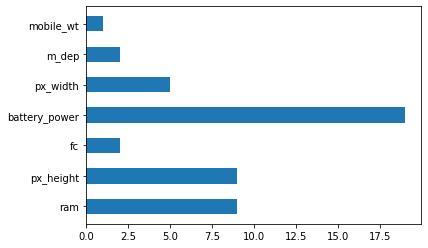

In [264]:
column_names = train_df.columns
x = []
h = []
label = []
cnt = 1
for key, value in clf_depth10.use_feature_times.items():
    print(column_names[key], ': ', value)
    x.append(cnt)
    h.append(value)
    label.append(column_names[key])
    cnt += 1

plt.barh(x, h, tick_label=label, height=0.5)  # 改成 barh
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

reference
1. video: https://www.youtube.com/watch?v=LsK-xG1cLYA&ab_channel=StatQuestwithJoshStarmer
2. mynote: https://docs.google.com/document/d/1xV7HK57fsWBgja9RaQnMaS60vXpGfnwloXDZAknZAL0/edit?usp=sharing

In [57]:
class AdaBoost():
    def __init__(self, n_estimators, decision_tree_max_depth=1, decision_tree_criterion = "gini"):
        self.n_estimators = n_estimators
        self.decision_tree_max_depth = decision_tree_max_depth
        self.decision_tree_criterion = decision_tree_criterion
        self.decision_tree_list = []
        self.amount_of_say_list = []

    def fit(self, x_data, y_data):
        # 1. 用現在的 data 丟進去 fit 出一顆 acc != 0.5 的 decision tree(stump 應該就可以ㄌ，maxdepth = 1)
        # 2. 把 train data 丟進去 predict
        # 3. 根據 predict 結果(每筆資料 label 是否正確)以及"每筆資料的 weight" 計算出 total error
        # 4. total error 算出 amount of say
        # 5. amount of say 分別去更新分對分錯資料的權重並 normalize
        # 6. 根據權重 get 出新的 dataset -> 下次選出來的 stump 才不會一樣
        # 7. next iteration from step 1
        data_number = x_data.shape[0]
        new_x = x_data
        new_y = y_data
        x_data_weight = []
        for i in range (data_number):  # shape[0] is how many rows
            x_data_weight.append(1/data_number)


        for n in range(self.n_estimators):
            # 1. initialize the weight to be all the same
            
            # 2. 用現在的 data 丟進去 fit 出一顆 acc != 0.5 的 decision tree
            #    -> *** 用 resample data fit
            #    -> *** 用 original data predict
            decision_tree = DecisionTree(criterion=self.decision_tree_criterion, max_depth=self.decision_tree_max_depth)
            decision_tree.fit(new_x, new_y)
            y_predict = decision_tree.predict(x_data) # predict on the "original x_data"
            
            # 3. calculate total error: sum of the weight of the incorrectly classified samples
            total_error = 0 
            for i in range(len(y_predict)):
                if y_predict[i] != y_data[i]: # 分錯了
                    total_error += x_data_weight[i]
            # print("total error ", n, ": ", total_error)
            
            # 4. amount of say calculate from total error
            # amount_of_say = (1/2) * (np.ln((1-total_error+small_val)/(total_error+small_val)))  # e 為底！！
            amount_of_say = (1/2) * (np.log((1-total_error+small_val)/(total_error+small_val)))

            # 5. calculate the new sample weight for each data
            #    check the label
            for i in range(len(y_predict)):
                if y_predict[i] == y_data[i]: # 分對了
                    x_data_weight[i] = x_data_weight[i] * np.exp(-amount_of_say)
                elif y_predict[i] != y_data[i]: # 分錯了
                    x_data_weight[i] = x_data_weight[i] * np.exp(amount_of_say)
            
            # 6. normalize the weight list to be 1 -> 有點誤差沒關係
            weight_sum = 0
            for weight in x_data_weight:
                weight_sum += weight
            for i in range(len(x_data_weight)):
                x_data_weight[i] /= weight_sum
            
            # *** 7. 根據新的 weight, 從最原始的 x_data 選出新的 data_set
            # range: 0 ~ len(data) -> get the data id
            # 需要選出 len(x_data) 這麼多個
            # 根據 weight 選
            new_data_id = np.random.choice(len(x_data), len(x_data), p=x_data_weight)

            # 8. 從 "最原始的 x_data" 拿出新的 data
            new_x = []
            new_y = []
            for id in new_data_id:
                new_x.append(x_data[id,:])
                new_y.append(y_data[id])
            new_x = np.stack(new_x, axis=0 ) # list of numpy array to 2D numpy array

            # 9. store the decision_tree and its amount of say -> store the structure of the adaboost
            self.decision_tree_list.append(decision_tree)
            self.amount_of_say_list.append(amount_of_say)

    def predict(self, x_data):
        y_predict_weight_sum = np.zeros(x_data.shape[0])  # y_predict length will be the same as x_data's number of rows

        # for decision_tree in self.decision_tree_list:
        for i in range(self.n_estimators):
            y_predict_label = self.decision_tree_list[i].predict(x_data) # the decision tree here is already trained and we only need the predict result
            # print("decision tree ", i, "acc: ", get_acc(y_predict_label, y_test_data))
            for j in range(len(y_predict_label)):
                if y_predict_label[j] == 0:  # class 0
                    y_predict_weight_sum[j] += -1 *  self.amount_of_say_list[i]
                elif y_predict_label[j] == 1:  # class 1
                    y_predict_weight_sum[j] += 1 *  self.amount_of_say_list[i]
    
        y_predict_result = []
        for weight_sum in y_predict_weight_sum:
            if weight_sum >= 0:  # 大等於判給 class1
                y_predict_result.append(1)
            else:                # 小於判給 class0
                y_predict_result.append(0)
        
        return np.array(y_predict_result)
        

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [266]:
adaboost_10 = AdaBoost(n_estimators=10, decision_tree_max_depth=1) # depth == 1 error 會沒辦法往下
adaboost_100 = AdaBoost(n_estimators=100, decision_tree_max_depth=1)

In [267]:
adaboost_10.fit(x_train_data, y_train_data)
print("adaboost_10 acc: ", get_acc(adaboost_10.predict(x_test_data), y_test_data))

adaboost_10 acc:  0.9433333333333334


In [269]:
adaboost_100.fit(x_train_data, y_train_data)
y_predict_adaboost_100 = adaboost_100.predict(x_test_data)
print("adaboost_100 acc: ", get_acc(adaboost_100.predict(x_test_data), y_test_data))

adaboost_100 acc:  0.97


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [271]:
# 'random_forest version's' decision tree
clf_gini_random = DecisionTree(criterion='gini', mode='random_forest', m=5)
clf_gini_random.fit(x_train_data, y_train_data)
print("clf_gini acc: ", get_acc(clf_gini_random.predict(x_test_data), y_test_data))

clf_gini acc:  0.8866666666666667


In [62]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(np.around(max_features))  # 四捨五入轉成整數
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.select_data_num = None
        self.decision_tree_list = []
        

    def fit(self, x_data, y_data):
        self.select_data_num = len(x_data)  # row value

        # random_select_x_data = x_data
        # random_select_y_data = y_data
    
        # 1. select n estimators
        for n in range(self.n_estimators):

            # sample data number == original data size
            if self.boostrap == True:
                random_select_x_data_id = np.random.choice(self.select_data_num, self.select_data_num, replace=True)  # range, number to select out
            elif self.boostrap == False:
                random_select_x_data_id = np.random.choice(self.select_data_num, self.select_data_num, replace=False)  # can not replace the data -> select 'all' number out from the range(0, N)
                
            random_select_x_data = []  # reset the dataset from random select
            random_select_y_data = []
            for id in  random_select_x_data_id:
                random_select_x_data.append(x_data[id])
                random_select_y_data.append(y_data[id])
            
            random_select_x_data = np.stack( random_select_x_data, axis=0 )  # need to convert list of np.array to np.array
            random_select_y_data = np.stack( random_select_y_data, axis=0 )
            
            decision_tree = DecisionTree(criterion='gini', mode='random_forest', m=self.max_features)
            decision_tree.fit(random_select_x_data, random_select_y_data)
            self.decision_tree_list.append(decision_tree)

    def predict(self, x_data):
        y_vote = np.zeros(len(x_data))

        for decision_tree in self.decision_tree_list:
            y_pred = decision_tree.predict(x_data)
            for i in range(len(y_pred)):
                if y_pred[i] == 0:  # class 0 then -1
                    y_vote[i] -= 1
                else:               # class 1 then +1
                    y_vote[i] += 1

        y_result = []
        for vote in y_vote:
            if vote < 0:
                y_result.append(0)  # 小於 0 -> class 0
            else:
                y_result.append(1)  # 大於等於 0 -> class 1

        return np.array(y_result)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [273]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train_data.shape[1]))  # feature ^ 1/2
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train_data.shape[1]))

In [274]:
clf_10tree.fit(x_train_data, y_train_data)
print("clf_10tree acc: ", get_acc(clf_10tree.predict(x_test_data), y_test_data))

clf_10tree acc:  0.9166666666666666


In [275]:
clf_100tree.fit(x_train_data, y_train_data)
print("clf_100tree acc: ", get_acc(clf_100tree.predict(x_test_data), y_test_data))

clf_100tree acc:  0.9433333333333334


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [277]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train_data.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train_data.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [278]:
clf_random_features.fit(x_train_data, y_train_data)
print("clf_random_features acc: ", get_acc(clf_random_features.predict(x_test_data), y_test_data))

clf_random_features acc:  0.9266666666666666


In [279]:
clf_all_features.fit(x_train_data, y_train_data)
print("clf_all_features acc: ", get_acc(clf_all_features.predict(x_test_data), y_test_data))

clf_all_features acc:  0.9533333333333334


### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [289]:
# def train_your_model(data):
#     ## Define your model and training 
#     return

def train_your_model(x_train_data, y_train_data):
    ## Define your model and training
    # adaboost_150 = AdaBoost(n_estimators=150, decision_tree_max_depth=1)
    # adaboost_150.fit(x_train_data, y_train_data)
    # return adaboost_150
    adaboost_170 = AdaBoost(n_estimators=170, decision_tree_max_depth=1)
    adaboost_170.fit(x_train_data, y_train_data)
    return adaboost_170

In [288]:
my_model = train_your_model(x_train_data, y_train_data)
my_pred = my_model.predict(x_test_data)
print("adaboost_170 acc: ", get_acc(my_pred, y_test_data))

adaboost_170 acc:  0.9833333333333333


In [283]:
assert y_pred.shape == (500, )

AttributeError: 'list' object has no attribute 'shape'

### train 丟 dataframe 但是 predict 的時候只能丟 np.array 因為 ‘train_your_model’ return 的是 adaboost 的 model

In [66]:
def train_your_model(data):
    ## Define your model and training 
    inside_x_train_data = data.drop(columns=['price_range']).to_numpy()
    inside_y_train_data = data.loc[:, 'price_range'].to_numpy()

    adaboost_170 = AdaBoost(n_estimators=170, decision_tree_max_depth=1)
    adaboost_170.fit(inside_x_train_data, inside_y_train_data)
    return adaboost_170

In [67]:
my_model_predict_on_val = train_your_model(train_df)  # 應該不能改 input -> valid_df 丟不進去 -> 那就 train 在 train_df 就好

In [69]:
y_pred_on_val = my_model_predict_on_val.predict(x_test_data)
print("adaboost_170 acc: ", get_acc(y_pred_on_val, y_test_data))

adaboost_170 acc:  0.97


In [83]:
x_test_df = pd.read_csv('x_test.csv')
print(x_test_df.shape)

x_test_df.head()

(500, 20)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1076,0,2.5,0,3,0,14,0.2,105,5,4,545,1300,2043,7,5,14,0,0,0
1,759,0,2.5,0,3,1,39,0.3,162,2,8,110,1317,968,6,2,2,1,0,0
2,1562,1,1.3,1,1,1,7,0.2,190,5,15,642,1533,2243,12,10,6,1,0,0
3,1954,0,0.6,1,8,0,7,0.9,126,3,9,673,690,3438,17,12,13,1,0,0
4,1989,0,2.5,1,0,1,41,0.8,94,3,13,1100,1497,1665,17,9,12,1,1,1


In [84]:
x_test = x_test_df.to_numpy()
print(x_test[0:5, :])

[[1.076e+03 0.000e+00 2.500e+00 0.000e+00 3.000e+00 0.000e+00 1.400e+01
  2.000e-01 1.050e+02 5.000e+00 4.000e+00 5.450e+02 1.300e+03 2.043e+03
  7.000e+00 5.000e+00 1.400e+01 0.000e+00 0.000e+00 0.000e+00]
 [7.590e+02 0.000e+00 2.500e+00 0.000e+00 3.000e+00 1.000e+00 3.900e+01
  3.000e-01 1.620e+02 2.000e+00 8.000e+00 1.100e+02 1.317e+03 9.680e+02
  6.000e+00 2.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [1.562e+03 1.000e+00 1.300e+00 1.000e+00 1.000e+00 1.000e+00 7.000e+00
  2.000e-01 1.900e+02 5.000e+00 1.500e+01 6.420e+02 1.533e+03 2.243e+03
  1.200e+01 1.000e+01 6.000e+00 1.000e+00 0.000e+00 0.000e+00]
 [1.954e+03 0.000e+00 6.000e-01 1.000e+00 8.000e+00 0.000e+00 7.000e+00
  9.000e-01 1.260e+02 3.000e+00 9.000e+00 6.730e+02 6.900e+02 3.438e+03
  1.700e+01 1.200e+01 1.300e+01 1.000e+00 0.000e+00 0.000e+00]
 [1.989e+03 0.000e+00 2.500e+00 1.000e+00 0.000e+00 1.000e+00 4.100e+01
  8.000e-01 9.400e+01 3.000e+00 1.300e+01 1.100e+03 1.497e+03 1.665e+03
  1.700e+01 9.000e+00 1.200e

In [48]:
# trainval_df = pd.merge(train_df, val_df)
# pd.concat([ironman1,ironman2])
print(train_df.shape)
print(val_df.shape)

trainval_df = train_df
trainval_df = trainval_df.append(val_df)
print(trainval_df.shape)

(1200, 21)
(300, 21)
(1500, 21)


/var/folders/vs/ppsthmjj5yj5d35sqj3jfz5m0000gn/T/ipykernel_32703/1807766568.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trainval_df = trainval_df.append(val_df)


In [ ]:
print(trainval_df.head() == train_df.head())
print(trainval_df.tail() == val_df.tail())

In [70]:
my_model = train_your_model(trainval_df)

In [86]:
my_pred_big = my_model.predict(x_test_data)
print("final model pred on adaboost_170 big acc: ", get_acc(my_pred_big, y_test_data))

final model pred on adaboost_170 big acc:  1.0


In [87]:
y_pred = my_model.predict(x_test)

In [88]:
np.save('y_pred.npy', y_pred)

In [75]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [77]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [79]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***


In [ ]:
# def load_dataset():
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
df = pd.read_csv(
    file_url,
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
            "Viscera weight", "Shell weight", "Age"]
)

df['Target'] = (df["Age"] > 15).astype(int)
df = df.drop(labels=["Age"], axis="columns")

train_idx = range(0, len(df), 10)
test_idx = range(1, len(df), 20)

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

x_train = train_df.drop(labels=["Target"], axis="columns")
feature_names = x_train.columns.values
x_train = x_train.values
y_train = train_df['Target'].values

x_test = test_df.drop(labels=["Target"], axis="columns")
x_test = x_test.values
y_test = test_df['Target'].values

print(x_train)
print(x_train.shape)
print(type(x_train))

print(y_train)
print(y_train.shape)
print(type(y_train))

print(feature_names)

[[0.435  0.335  0.11   ... 0.1355 0.0775 0.0965]
 [0.625  0.495  0.155  ... 0.46   0.1945 0.34  ]
 [0.57   0.435  0.15   ... 0.3875 0.156  0.245 ]
 ...
 [0.43   0.34   0.125  ... 0.1375 0.061  0.146 ]
 [0.535  0.415  0.135  ... 0.3165 0.169  0.2365]
 [0.295  0.22   0.07   ... 0.0575 0.0295 0.035 ]]
(332, 7)
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 